<a href="https://colab.research.google.com/github/lblogan14/master_tensorflow_keras/blob/master/ch14_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generative models are trained to generate more data similar to the one they are trained on,
and adversarial models are trained to distinguish the real versus fake data by providing
adversarial examples.

The **Generative Adversarial Networks** (GAN) combine the features of both the models. \\
The GANs have two components:
* A *generative model* that learns how to generate similar data
* A *discriminative model* that learns how to distinguish between the real and
generated data (from the generative model)

###Code Prerequisite

In [41]:
import numpy as np
np.random.seed(123)
print("NumPy:{}".format(np.__version__))

import pandas as pd
print("Pandas:{}".format(pd.__version__))

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=15,10
print("Matplotlib:{}".format(mpl.__version__))

import tensorflow as tf
tf.set_random_seed(123)
print("TensorFlow:{}".format(tf.__version__))

import keras
print("Keras:{}".format(keras.__version__))

NumPy:1.14.6
Pandas:0.22.0
Matplotlib:2.1.2
TensorFlow:1.12.0
Keras:2.2.4


#Generative Adversarial Networks 101
![alt text](https://github.com/armando-fandango/Mastering-TensorFlow/blob/master/images/ch-14/14-01.png?raw=true)

The generator model generates data starting from random noise but slowly
learns how to generate more realistic data. The generator output and the real data is fed into
the discriminator that learns how to differentiate fake data from real data.

Thus, both generator and discriminator play an adversarial game where
the generator tries to fool the discriminator by generating as real data as
possible, and the discriminator tries not to be fooled by identifying fake
data from real data, thus the discriminator tries to minimize the
classification loss.

Mathematically, the generative model $G(z)$ learns the probability distribution $p(z)$ such that the discriminator $D(G(z), x)$ is unable to identify between the probability distributions, $p(z)$ and $p(x)$. \\
The objective function of the GAN can be described by the following equation describing the value function $V$,
$$\min_G\max_D V(D, G)= E_{x\sim p_{data}(x)}[\log D(x)]+E_{z\sim p_z(z)}[\log(1-D(G(z)))]$$
This description represents a simple GAN (a.k.a the vanilla GAN)

In conditional GANs, the generator and the discriminator networks are provided with the labels such that the objective function of the conditional GAN can be described by the following equation describing the value function $V$:
$$\min_G\max_D V(D, G)= E_{x\sim p_{data}(x)}[\log D(x)]+E_{z\sim p_z(z)}[\log(1-D(G(z, y), y))]$$

In this session, we will practice creating a simple GAN using the MNIST dataset. Before getting into the details, we need to normalize the MNIST dataset to lie between [-1, +1],

In [0]:
def norm(x):
  return (x-0.5)/0.5

Also, define the random noise with 256 dimensions that would be used to test the generator models:

In [0]:
n_z = 256
z_test = np.random.uniform(-1.0, 1.0, size=[8, n_z])

We also have a helper function to display the generated images that would be used in all the examples in this session,

In [0]:
def display_images(images):
  for i in range(images.shape[0]):
    plt.subplot(1, 8, i+1)
    plt.imshow(images[i])
    plt.axis('off')
  plt.tight_layout()
  plt.show()

##Get the MNIST data

In [45]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('mnist', one_hot=False)
x_train = mnist.train.images
x_test = mnist.test.images
y_train = mnist.train.labels
y_test = mnist.test.labels
pixel_size = 28

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


#Best practices for building and training GANS
For the dataset we selected for this demonstration, the discriminator was becoming very
good at classifying the real and fake images, and therefore not providing much of the
feedback in terms of gradients to the generator. Hence we had to make the discriminator
weak with the following best practices:
* The learning rate of the discriminator is kept much higher than the learning rate
of the generator.
* The optimizer for the discriminator is `GradientDescent` and the optimizer for
the generator is `Adam`.
* The discriminator has dropout regularization while the generator does not.
* The discriminator has fewer layers and fewer neurons as compared to the
generator.
* The output of the generator is `tanh` while the output of the discriminator is
`sigmoid`.
* In the Keras model, we use a value of 0.9 instead of 1.0 for labels of real data and
we use 0.1 instead of 0.0 for labels of fake data, in order to introduce a little bit of
noise in the labels

#Simple GAN with TensorFlow

In [0]:
tf.reset_default_graph()
keras.backend.clear_session()

For building the GAN with TensorFlow, we build three networks, two discriminator models, and one generator model.

1. Add parameters

In [0]:
# graph hyperparameters
g_learning_rate = 0.00001
d_learning_rate = 0.01

# number of pixels in the MNIST image as number of inputs
n_x = 28*28

# number of hidden layers for generator and discriminator
g_n_layers = 3
d_n_layers = 1
# neurons in each hidden layer
g_n_neurons = [256, 512, 1024]
d_n_neurons = [256]

# define parameter dictionary
g_params = {}
d_params = {}

activation = tf.nn.leaky_relu
w_initializer = tf.glorot_uniform_initializer
b_initializer = tf.zeros_initializer

2. Define the generator network

In [0]:
# define geenrator

z_p = tf.placeholder(dtype=tf.float32, name='z_p', shape=[None, n_z])
layer = z_p

# add generator network weights, biases and layers
with tf.variable_scope('g'):
  for i in range(0, g_n_layers):
    w_name = 'w_{0:04d}'.format(i)
    g_params[w_name] = tf.get_variable(name=w_name,
                                       shape=[n_z if i==0 else g_n_neurons[i-1], 
                                              g_n_neurons[i]],
                                       initializer=w_initializer())
    b_name = 'b_{0:04d}'.format(i)
    g_params[b_name] = tf.get_variable(name=b_name,
                                       shape=[g_n_neurons[i]],
                                       initializer=b_initializer())
    
    layer = activation(tf.matmul(layer, g_params[w_name]) + g_params[b_name])
    
  # output (logit) layer
  i = g_n_layers
  w_name = 'w_{0:04d}'.format(i)
  g_params[w_name] = tf.get_variable(name=w_name,
                                     shape=[g_n_neurons[i-1], n_x],
                                     initializer=w_initializer())
  b_name = 'b_{0:04d}'.format(i)
  g_params[b_name] = tf.get_variable(name=b_name,
                                     shape=[n_x],
                                     initializer=b_initializer())
  g_logit = tf.matmul(layer, g_params[w_name]) + g_params[b_name]
  g_model = tf.nn.tanh(g_logit)

3. Define the weights and biases for the two discriminator networks

In [0]:
# Define discriminator(s)

# add discriminator network weights, biases
with tf.variable_scope('d'):
  for i in range(0, d_n_layers):
    w_name = 'w_{0:04d}'.format(i)
    d_params[w_name] = tf.get_variable(name=w_name,
                                       shape=[n_x if i==0 else d_n_neurons[i-1], 
                                              d_n_neurons[i]],
                                       initializer=w_initializer())
    b_name = 'b_{0:04d}'.format(i)
    d_params[b_name] = tf.get_variable(name=b_name,
                                       shape=[d_n_neurons[i]],
                                       initializer=b_initializer())
    
  # output (logit) layer
  i = d_n_layers
  w_name = 'w_{0:04d}'.format(i)
  d_params[w_name] = tf.get_variable(name=w_name,
                                     shape=[d_n_neurons[i-1], 1],
                                     initializer=w_initializer())
  b_name = 'b_{0:04d}'.format(i)
  d_params[b_name] = tf.get_variable(name=b_name,
                                     shape=[1],
                                     initializer=b_initializer())

4. Using these parameters, build the discriminator that takes the real images as input and outputs the classification,

In [0]:
# define discriminator_real

# input real images
x_p = tf.placeholder(dtype=tf.float32, name='x_p', shape=[None, n_x])

layer = x_p

with tf.variable_scope('d'):
  for i in range(0, d_n_layers):
    w_name = 'w_{0:04d}'.format(i)
    b_name = 'b_{0:04d}'.format(i)
    
    layer = activation(tf.matmul(layer, d_params[w_name]) + d_params[b_name])
    layer = tf.nn.dropout(layer, 0.7)
  
  # output (logit) layer
  i = d_n_layers
  w_name = 'w_{0:04d}'.format(i)
  b_name = 'b_{0:04d}'.format(i)
  d_logit_real = tf.matmul(layer, d_params[w_name]) + d_params[b_name]
  d_model_real = tf.nn.sigmoid(d_logit_real)

5. Build another discriminator network, with the same parameters, but providing the output of generator as input,

In [0]:
# define discriminator_fake

# input generated fake images
z = g_model

layer = z

with tf.variable_scope('d'):
  for i in range(0, d_n_layers):
    w_name = 'w_{0:04d}'.format(i)
    b_name = 'b_{0:04d}'.format(i)

    layer = activation(tf.matmul(layer, d_params[w_name]) + d_params[b_name])
    layer = tf.nn.dropout(layer,0.7)
    
  #output (logit) layer
  i = d_n_layers
  w_name = 'w_{0:04d}'.format(i)
  b_name = 'b_{0:04d}'.format(i)
  d_logit_fake = tf.matmul(layer, d_params[w_name]) + d_params[b_name]
  d_model_fake = tf.nn.sigmoid(d_logit_fake)

6. Define the loss, optimizer, and training function to connect those three networks.\\
While training the generator, we only train the generator's parameters and while training the discriminator, we
only train the discriminator's parameters. We specify this using the `var_list`
parameter to the optimizer's `minimize()` function.

In [0]:
g_loss = -tf.reduce_mean(tf.log(d_model_fake))
d_loss = -tf.reduce_mean(tf.log(d_model_real) + tf.log(1 - d_model_fake))

g_optimizer = tf.train.AdamOptimizer(g_learning_rate)
d_optimizer = tf.train.GradientDescentOptimizer(d_learning_rate)

g_train_op = g_optimizer.minimize(g_loss, var_list=list(g_params.values()))
d_train_op = d_optimizer.minimize(d_loss, var_list=list(d_params.values()))

Now that we have defined the models, we have to train the models.

Epoch: 0000    d_loss = 0.379806    g_loss = 1.406252


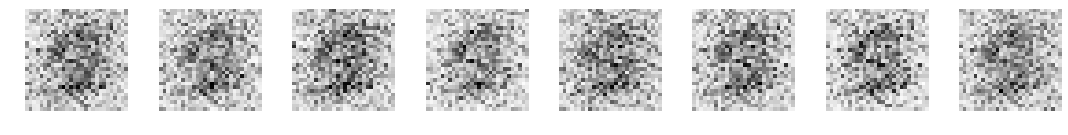

Epoch: 0050    d_loss = 0.457712    g_loss = 2.932264


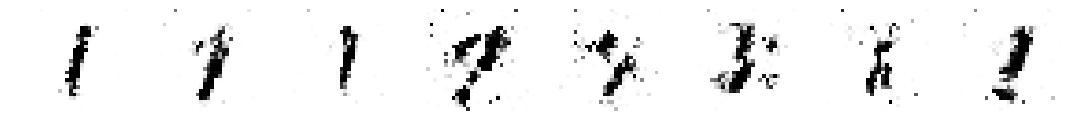

Epoch: 0100    d_loss = 0.746879    g_loss = 2.005963


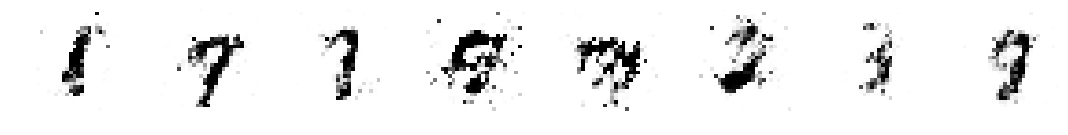

Epoch: 0150    d_loss = 0.964485    g_loss = 1.447550


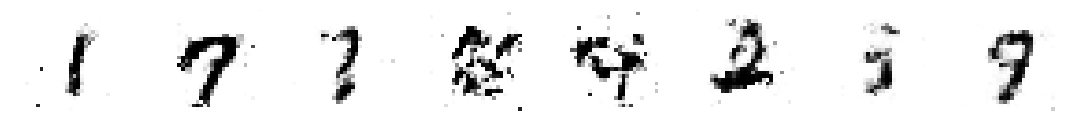

Epoch: 0200    d_loss = 1.059606    g_loss = 1.259055


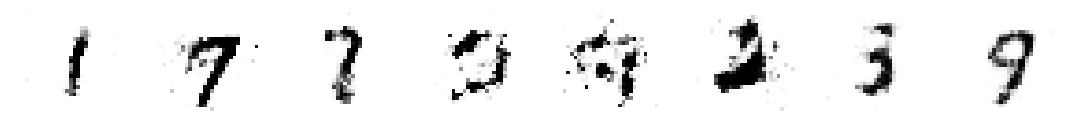

Epoch: 0250    d_loss = 1.097757    g_loss = 1.170724


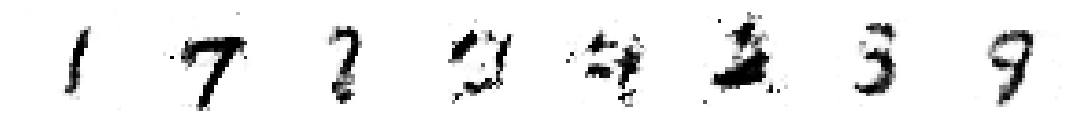

Epoch: 0300    d_loss = 1.153217    g_loss = 1.094100


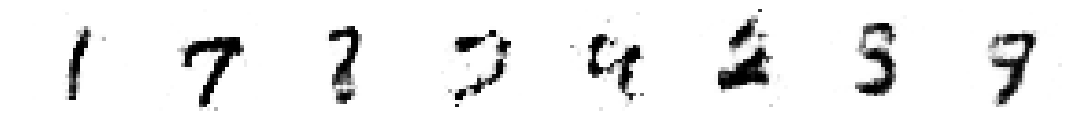

Epoch: 0350    d_loss = 1.171772    g_loss = 1.052586


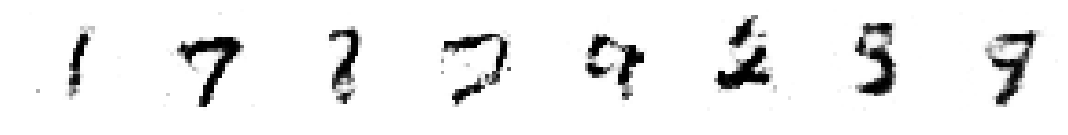

Epoch: 0400    d_loss = 1.189628    g_loss = 1.017803


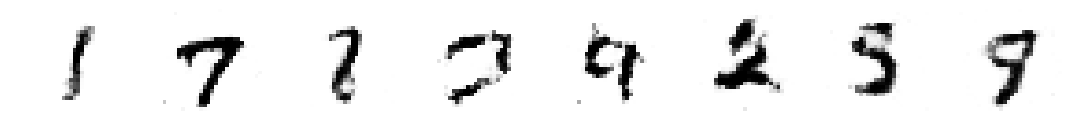

In [14]:
# training
n_epochs = 400
batch_size = 100
n_batches = int(mnist.train.num_examples / batch_size)

n_epochs_print = 50

with tf.Session() as tfs:
  tfs.run(tf.global_variables_initializer())
  for epoch in range(n_epochs+1):
    epoch_d_loss = 0.0
    epoch_g_loss = 0.0
    for batch in range(n_batches):
      x_batch, _ = mnist.train.next_batch(batch_size)
      x_batch = norm(x_batch)
      z_batch = np.random.uniform(-1.0, 1.0, size=[batch_size, n_z])
      feed_dict = {x_p:x_batch, z_p:z_batch}
      _, batch_d_loss = tfs.run([d_train_op, d_loss], feed_dict=feed_dict)
      
      z_batch = np.random.uniform(-1.0, 1.0, size=[batch_size, n_z])
      feed_dict = {z_p:z_batch}
      _, batch_g_loss = tfs.run([g_train_op, g_loss], feed_dict=feed_dict)
      
      epoch_d_loss += batch_d_loss
      epoch_g_loss += batch_g_loss
      
    if epoch%n_epochs_print == 0:
      average_d_loss = epoch_d_loss / n_batches
      average_g_loss = epoch_g_loss / n_batches
      print('Epoch: {0:04d}    d_loss = {1:0.6f}    g_loss = {2:0.6f}'
            .format(epoch, average_d_loss, average_g_loss))
      
      # predict images using generator model trained
      x_pred = tfs.run(g_model, feed_dict={z_p:z_test})
      display_images(x_pred.reshape(-1, pixel_size, pixel_size))

#Simple GAN with Keras

In [0]:
import keras
from keras.layers import Dense, Input, LeakyReLU, Dropout
from keras.models import Sequential, Model

In [0]:
tf.reset_default_graph()
keras.backend.clear_session()

1. Define hyperparameters

In [0]:
# graph hyperparameters
g_learning_rate = 0.00001
d_learning_rate = 0.01

# number of pixels in the MNIST image as number of inputs
n_x = 784  

# number of hidden layers for generator and discriminator
g_n_layers = 3
d_n_layers = 1
# neurons in each hidden layer
g_n_neurons = [256, 512, 1024]
d_n_neurons = [256]

2. Define the generator network

In [23]:
g_model = Sequential()
g_model.add(Dense(units=g_n_neurons[0], input_shape=(n_z,), name='g_0'))
g_model.add(LeakyReLU())
for i in range(1, g_n_layers):
  g_model.add(Dense(units=g_n_neurons[i], name='g_{}'.format(i)))
  g_model.add(LeakyReLU())
g_model.add(Dense(units=n_x, activation='tanh', name='g_out'))
print('Generator:')
g_model.summary()
g_model.compile(loss='binary_crossentropy', 
                optimizer=keras.optimizers.Adam(lr=g_learning_rate))

Generator:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
g_0 (Dense)                  (None, 256)               65792     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
g_1 (Dense)                  (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
g_2 (Dense)                  (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
g_out (Dense)                (None, 784)               803600    

3. In the Keras example, we do not define two discriminator networks as we
defined in the TensorFlow example. \\
Instead, we define one discriminator
network and then stitch the generator and discriminator network into the GAN
network. \\
The *GAN network* is then used to **train the generator parameters only**,
and the *discriminator network* is used to **train the discriminator parameters**:

In [24]:
# define discriminator
d_model = Sequential()
d_model.add(Dense(units=d_n_neurons[0], input_shape=(n_x,), name='d_0'))
d_model.add(LeakyReLU())
d_model.add(Dropout(0.3))
for i in range(1, d_n_layers):
  d_model.add(Dense(units=d_n_neurons[i], name='d_{}'.format(i)))
  d_model.add(LeakyReLU())
  d_model.add(Dropout(0.3))
d_model.add(Dense(units=1, activation='sigmoid', name='d_out'))
print('Discriminator:')
d_model.summary()
d_model.compile(loss='binary_crossentropy',
                optimizer=keras.optimizers.SGD(lr=d_learning_rate))

Discriminator:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
d_0 (Dense)                  (None, 256)               200960    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
d_out (Dense)                (None, 1)                 257       
Total params: 201,217
Trainable params: 201,217
Non-trainable params: 0
_________________________________________________________________


4. Define the GAN Network, and turn the trainable property of the
discriminator model to `false`, since **GAN would only be used to train the
generator**:

In [25]:
d_model.trainable = False
z_in = Input(shape=(n_z,), name='z_in')
x_in = g_model(z_in)
gan_out = d_model(x_in)

gan_model = Model(inputs=z_in, outputs=gan_out, name='gan')
print('GAN:')
gan_model.summary()
gan_model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(lr=g_learning_rate))

GAN:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_in (InputLayer)            (None, 256)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 784)               1526288   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 201217    
Total params: 1,727,505
Trainable params: 1,526,288
Non-trainable params: 201,217
_________________________________________________________________


5. Train the models. \\
For setting the labels, we apply the labels as 0.9 and 0.1 for real and fake images
respectively. Generally, it is suggested that you use label smoothing by picking a random
value from 0.0 to 0.3 for fake data and 0.8 to 1.0 for real data.

Epoch: 0000    d_loss = 0.492748    g_loss = 0.86995


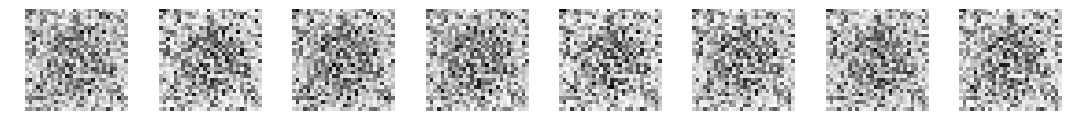

Epoch: 0050    d_loss = 0.502737    g_loss = 1.41072


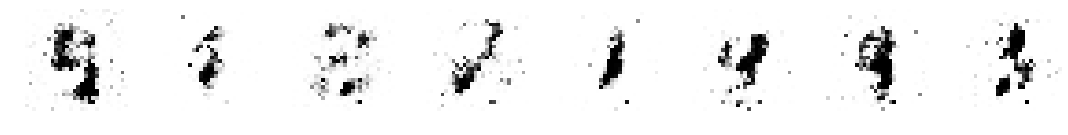

Epoch: 0100    d_loss = 0.545590    g_loss = 1.25962


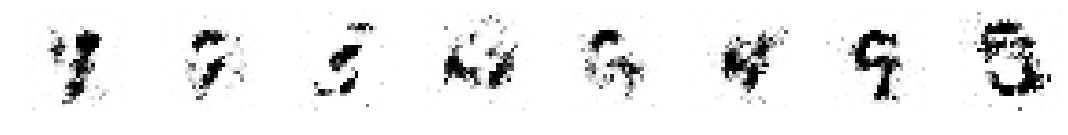

Epoch: 0150    d_loss = 0.578594    g_loss = 1.12632


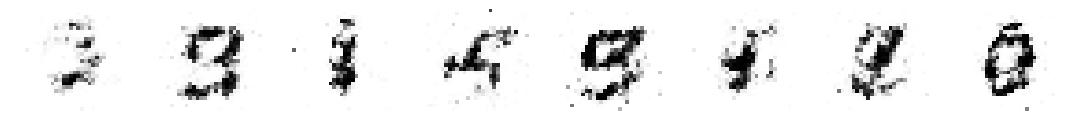

Epoch: 0200    d_loss = 0.609183    g_loss = 1.01533


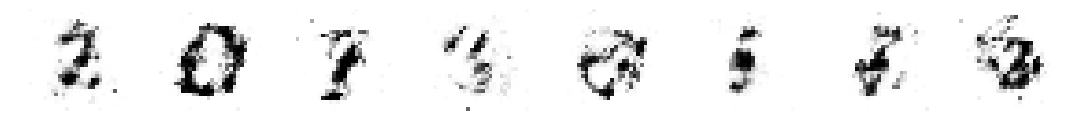

Epoch: 0250    d_loss = 0.649322    g_loss = 0.86522


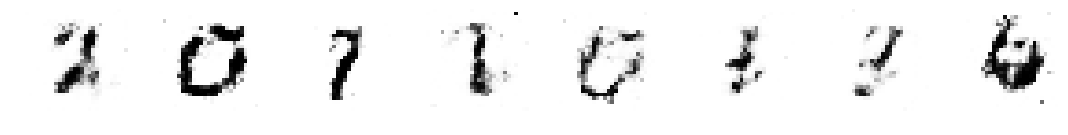

Epoch: 0300    d_loss = 0.660447    g_loss = 0.82348


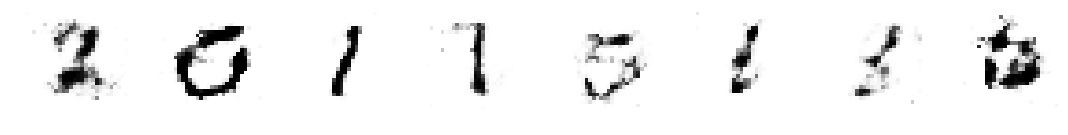

Epoch: 0350    d_loss = 0.664320    g_loss = 0.80263


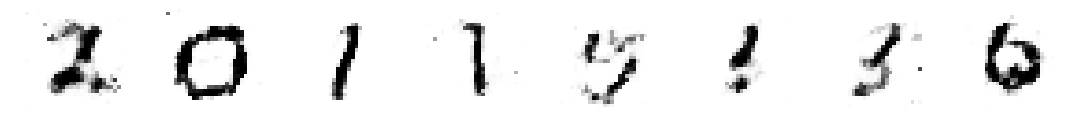

Epoch: 0400    d_loss = 0.666747    g_loss = 0.78965


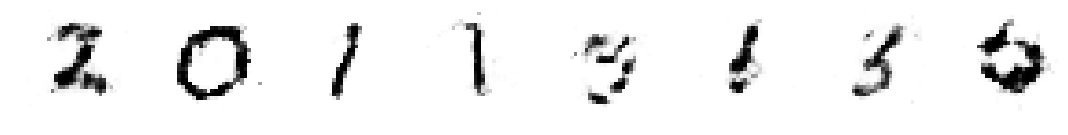

In [27]:
# training hyperparameters
n_epochs = 400
batch_size = 100
n_batches = int(mnist.train.num_examples / batch_size)
n_epochs_print = 50

for epoch in range(n_epochs+1):
  epoch_d_loss = 0.0
  epoch_g_loss = 0.0
  for batch in range(n_batches):
    x_batch, _ = mnist.train.next_batch(batch_size)
    x_batch = norm(x_batch)
    z_batch = np.random.uniform(-1.0, 1.0, size=[batch_size, n_z])
    g_batch = g_model.predict(z_batch)
    
    x_in = np.concatenate([x_batch, g_batch])
    
    y_out = np.ones(batch_size*2)
    y_out[:batch_size] = 0.9
    y_out[batch_size:] = 0.1
    
    d_model.trainable = True
    batch_d_loss = d_model.train_on_batch(x_in, y_out)
    
    z_batch = np.random.uniform(-1.0, 1.0, size=[batch_size, n_z])
    x_in = z_batch
    
    y_out = np.ones(batch_size)
    
    d_model.trainable = False
    batch_g_loss = gan_model.train_on_batch(x_in, y_out)
    
    epoch_d_loss += batch_d_loss
    epoch_g_loss += batch_g_loss
  if epoch%n_epochs_print == 0:
    average_d_loss = epoch_d_loss / n_batches
    average_g_loss = epoch_g_loss / n_batches
    print('Epoch: {0:04d}    d_loss = {1:0.6f}    g_loss = {2:0.5f}'
          .format(epoch, average_d_loss, average_g_loss))
    # predict images using generator model trained
    x_pred = g_model.predict(z_test)
    display_images(x_pred.reshape(-1, pixel_size, pixel_size))

#Deep Convolutional GAN (DCGAN) with Keras
In DCGAN, both the discriminator and generator are implemented using a Deep Convolutional Network

In [0]:
import keras
from keras.layers import Dense, Input, LeakyReLU, Activation
from keras.layers import UpSampling2D,   Conv2D, Reshape, Flatten, MaxPooling2D
from keras.models import Sequential, Model

In [0]:
tf.reset_default_graph()
keras.backend.clear_session()

In [0]:
# graph hyperparameters
g_learning_rate = 0.00001
d_learning_rate = 0.01

n_x = 784  # number of pixels in the MNIST image as number of inputs

# number of hidden layers for generator and discriminator
g_n_layers = 3
d_n_layers = 1
# filters in each hidden layer
g_n_filters = [64,32,16]
d_n_filters = [64]

n_width=28
n_height=28
n_depth=1

1. Build a generator having three convolutional layers followed by tanh activation,

In [49]:
# define generator
g_model = Sequential(name='g')
g_model.add(Dense(units=5*5*128, input_shape=(n_z,), name='g_in'))
g_model.add(Activation('tanh', name='g_in_act'))

g_model.add(Reshape(target_shape=(5, 5, 128), 
                    input_shape=(5*5*128,),
                    name='g_in_reshape'))

for i in range(0, g_n_layers):
  g_model.add(UpSampling2D(size=[2,2], name='g_{}_up2d'.format(i)))
  g_model.add(Conv2D(filters=g_n_filters[i],
                     kernel_size=(5, 5),
                     padding='SAME',
                     name='g_{}_conv2d'.format(i)))
  g_model.add(Activation('tanh', name='g_{}_act'.format(i)))
  
g_model.add(Flatten(name='g_out_flatten'))

g_model.add(Dense(units=n_x, activation='tanh', name='g_out'))
print('Generator:')
g_model.summary()
g_model.compile(loss='binary_crossentropy',
                optimizer=keras.optimizers.Adam(lr=g_learning_rate))

Generator:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
g_in (Dense)                 (None, 3200)              822400    
_________________________________________________________________
g_in_act (Activation)        (None, 3200)              0         
_________________________________________________________________
g_in_reshape (Reshape)       (None, 5, 5, 128)         0         
_________________________________________________________________
g_0_up2d (UpSampling2D)      (None, 10, 10, 128)       0         
_________________________________________________________________
g_0_conv2d (Conv2D)          (None, 10, 10, 64)        204864    
_________________________________________________________________
g_0_act (Activation)         (None, 10, 10, 64)        0         
_________________________________________________________________
g_1_up2d (UpSampling2D)      (None, 20, 20, 64)        0         

2. Define the discriminator,

In [50]:
d_model = Sequential(name='d')
d_model.add(Reshape(target_shape=(n_width, n_height, n_depth),
                    input_shape=(n_x,),
                    name='d_0_reshape'))

for i in range(0, d_n_layers):
  d_model.add(Conv2D(filters=d_n_filters[i],
                     kernel_size=(5, 5),
                     padding='SAME',
                     name='d_{}_conv2d'.format(i)))
  d_model.add(Activation('tanh', name='d_{}_act'.format(i)))
  d_model.add(MaxPooling2D(pool_size=(2, 2),
                           strides=(2, 2),
                           name='d_{}_maxpool'.format(i)))
  
d_model.add(Flatten(name='d_out_flatten'))
d_model.add(Dense(units=1, activation='sigmoid', name='d_out'))
print('Discriminator:')
d_model.summary()
d_model.compile(loss='binary_crossentropy',
                optimizer=keras.optimizers.SGD(lr=d_learning_rate))

Discriminator:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
d_0_reshape (Reshape)        (None, 28, 28, 1)         0         
_________________________________________________________________
d_0_conv2d (Conv2D)          (None, 28, 28, 64)        1664      
_________________________________________________________________
d_0_act (Activation)         (None, 28, 28, 64)        0         
_________________________________________________________________
d_0_maxpool (MaxPooling2D)   (None, 14, 14, 64)        0         
_________________________________________________________________
d_out_flatten (Flatten)      (None, 12544)             0         
_________________________________________________________________
d_out (Dense)                (None, 1)                 12545     
Total params: 14,209
Trainable params: 14,209
Non-trainable params: 0
_________________________________________________________

3. The GAN network is composed of the discriminator and generator,

In [51]:
d_model.trainable = False
z_in = Input(shape=(n_z,), name='z_in')
x_in = g_model(z_in)
gan_out = d_model(x_in)

gan_model = Model(inputs=z_in, outputs=gan_out, name='gan')
print('GAN:')
gan_model.summary()
gan_model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(lr=g_learning_rate))

GAN:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_in (InputLayer)            (None, 256)               0         
_________________________________________________________________
g (Sequential)               (None, 784)               21162496  
_________________________________________________________________
d (Sequential)               (None, 1)                 14209     
Total params: 21,176,705
Trainable params: 21,162,496
Non-trainable params: 14,209
_________________________________________________________________


4. Training,

epoch: 0000   d_loss = 0.535614  g_loss = 1.156275


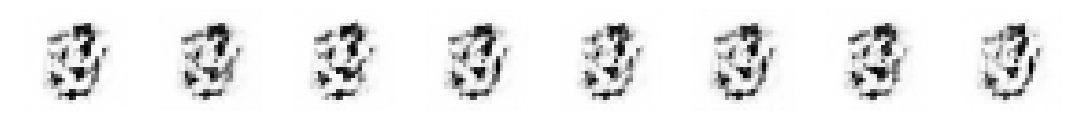

epoch: 0050   d_loss = 0.698813  g_loss = 0.736866


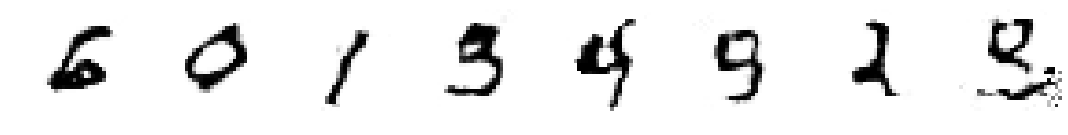

epoch: 0100   d_loss = 0.700716  g_loss = 0.698594


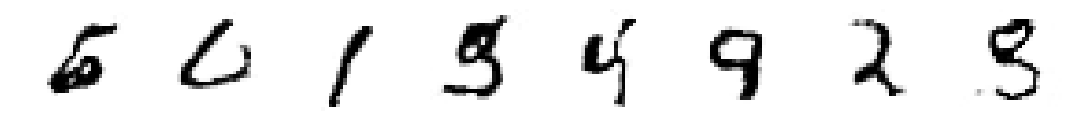

In [0]:
# training hyperparameters

n_epochs = 400
batch_size = 100
n_batches = int(mnist.train.num_examples / batch_size)
n_epochs_print = 50

for epoch in range(n_epochs+1):
  epoch_d_loss = 0.0
  epoch_g_loss = 0.0
  for batch in range(n_batches):
    x_batch, _ = mnist.train.next_batch(batch_size)
    x_batch = norm(x_batch)
    z_batch = np.random.uniform(-1.0,1.0,size=[batch_size,n_z])
    g_batch = g_model.predict(z_batch)
        
    x_in = np.concatenate([x_batch,g_batch])
    
    y_out = np.ones(batch_size*2)
    y_out[:batch_size]=0.9
    y_out[batch_size:]=0.1
        
    d_model.trainable=True
    batch_d_loss = d_model.train_on_batch(x_in,y_out)

    z_batch = np.random.uniform(-1.0,1.0,size=[batch_size,n_z])
    x_in=z_batch
        
    y_out = np.ones(batch_size)
            
    d_model.trainable=False
    batch_g_loss = gan_model.train_on_batch(x_in,y_out)
        
    epoch_d_loss += batch_d_loss 
    epoch_g_loss += batch_g_loss 
  if epoch%n_epochs_print == 0:
    average_d_loss = epoch_d_loss / n_batches
    average_g_loss = epoch_g_loss / n_batches
    print('epoch: {0:04d}   d_loss = {1:0.6f}  g_loss = {2:0.6f}'
              .format(epoch,average_d_loss,average_g_loss))
    # predict images using generator model trained            
    x_pred = g_model.predict(z_test)
    display_images(x_pred.reshape(-1,pixel_size,pixel_size))